# LSTM-Based Remaining Useful Life (RUL) Prediction
This notebook builds and trains an LSTM model to predict the Remaining Useful Life (RUL) of engines using the C-MAPSS FD004 dataset. It compares performance using the original dataset versus GAN-augmented data to evaluate the impact of synthetic fault injection on prediction accuracy.

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import os
from sklearn.metrics import mean_squared_error, mean_absolute_error


In [2]:
# Load original and GAN-augmented datasets
df_original = pd.read_csv('../data/processed/cmapss_fd004_preprocessed.csv')

aug_path = '../data/processed/cmapss_fd004_augmented.csv'
df_augmented = pd.read_csv(aug_path) if os.path.exists(aug_path) else df_original.copy()

print('Original shape:', df_original.shape)
print('Augmented shape:', df_augmented.shape)

Original shape: (61249, 27)
Augmented shape: (61249, 27)


In [3]:
class RULDataset(Dataset):
    def __init__(self, df, window_size=50):
        self.sequences = []
        self.targets = []
        sensor_cols = [col for col in df.columns if 'sensor_' in col]
        units = df['unit'].unique()
        for unit in units:
            unit_df = df[df['unit'] == unit].reset_index(drop=True)
            for i in range(len(unit_df) - window_size):
                seq = unit_df.loc[i:i+window_size-1, sensor_cols].values
                rul = unit_df.loc[i+window_size-1, 'RUL']
                self.sequences.append(seq)
                self.targets.append(rul)

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return torch.tensor(self.sequences[idx], dtype=torch.float32), torch.tensor(self.targets[idx], dtype=torch.float32)

In [4]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=64):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        _, (hn, _) = self.lstm(x)
        return self.fc(hn[-1])

## Training and Evaluation

In [5]:
# Prepare dataset and model
window_size = 50
batch_size = 64
epochs = 15
lr = 0.001

# Choose dataset
use_augmented = True
df_used = df_augmented if use_augmented else df_original

dataset = RULDataset(df_used, window_size=window_size)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

sensor_cols = [col for col in df_used.columns if 'sensor_' in col]
model = LSTMModel(input_size=len(sensor_cols)).to('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_losses = []
model.train()
for epoch in range(epochs):
    batch_losses = []
    for X_batch, y_batch in dataloader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch).squeeze()
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        batch_losses.append(loss.item())
    avg_loss = np.mean(batch_losses)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

Epoch 1/15, Loss: 13364.3858
Epoch 2/15, Loss: 8286.0717
Epoch 3/15, Loss: 6644.6938
Epoch 4/15, Loss: 6306.7555
Epoch 5/15, Loss: 6205.0290
Epoch 6/15, Loss: 4016.8792
Epoch 7/15, Loss: 3121.1725
Epoch 8/15, Loss: 2726.2382
Epoch 9/15, Loss: 2393.8270
Epoch 10/15, Loss: 2228.8628
Epoch 11/15, Loss: 2072.4478
Epoch 12/15, Loss: 1975.8767
Epoch 13/15, Loss: 1895.8535
Epoch 14/15, Loss: 1828.9262
Epoch 15/15, Loss: 1761.1711


In [6]:
# Evaluate on entire dataset
model.eval()
all_preds = []
all_targets = []
with torch.no_grad():
    for X_batch, y_batch in dataloader:
        X_batch = X_batch.to(device)
        preds = model(X_batch).squeeze().cpu().numpy()
        all_preds.extend(preds)
        all_targets.extend(y_batch.numpy())

rmse = np.sqrt(mean_squared_error(all_targets, all_preds))
mae = mean_absolute_error(all_targets, all_preds)
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

RMSE: 40.63
MAE: 27.54


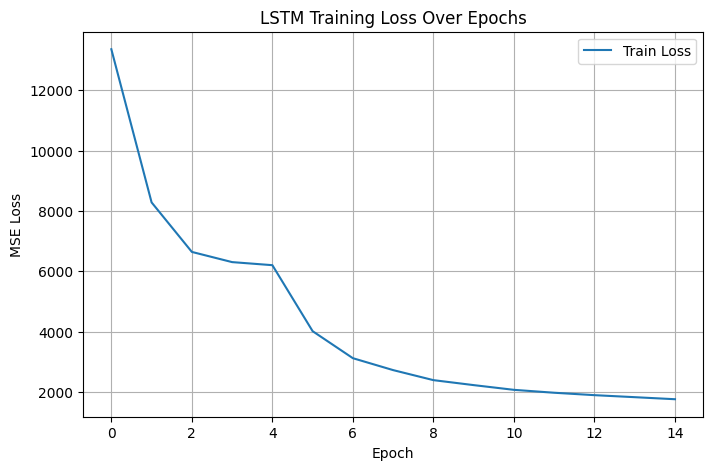

In [7]:
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Train Loss')
plt.title('LSTM Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.grid(True)
plt.legend()
plt.show()

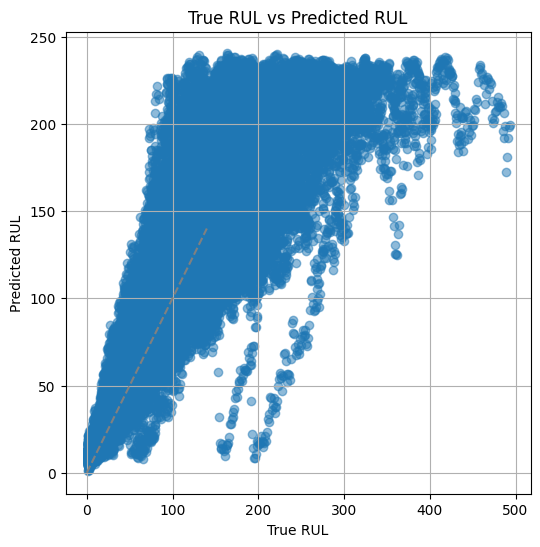

In [8]:
plt.figure(figsize=(6, 6))
plt.scatter(all_targets, all_preds, alpha=0.5)
plt.plot([0, 140], [0, 140], '--', color='gray')
plt.title('True RUL vs Predicted RUL')
plt.xlabel('True RUL')
plt.ylabel('Predicted RUL')
plt.grid(True)
plt.show()

In [9]:
# Save the trained model
torch.save(model.state_dict(), '../data/processed/lstm_rul_model.pth')
print("✅ LSTM model saved to ../data/processed/lstm_rul_model.pth")


✅ LSTM model saved to ../data/processed/lstm_rul_model.pth
